# **Sale Price Study Notebook**

## Objectives

*   Answer business requirement 1: 
    * The client is interested in discovering how their houses attributes correlate with the typical house Sale Price.

## Inputs

* Generate Dataset: outputs/datasets/collection/HeritageHousing.csv

## Outputs

* Generate code that answers business requirement 1 and can later be used to build a Streamlit App

---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues-P5/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues-P5'

---

# Load Data

In [4]:
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/HeritageHousing.csv")
    )
df.head(5)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


---

# Correlation Study

In [5]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df=df, minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

From the overview above we can see that there is a lot of missing data. 

In order to run correlation functions using pearson and spearman methods however we need to make sure there are no missing values.

First, let's drop the columns that have the highest number of missing values.

In [6]:
df = df.drop(columns=['EnclosedPorch', 'GarageFinish', 'WoodDeckSF', 'LotFrontage'])


Then, we can drop the rest of the rows with missing data.

In [7]:
df = df.dropna()

df.index

Int64Index([   0,    1,    2,    5,    6,    7,    8,    9,   10,   12,
            ...
            1444, 1445, 1447, 1448, 1451, 1452, 1454, 1455, 1457, 1459],
           dtype='int64', length=1111)

After roughly cutting out the missing data, we still have plenty left over for this first part of our study. We may look to fill these values instead later on.

Next we use one hot encoder to seperate the different object types of data into binary values. For example we're seperating the overall quality variable into columns of the values 1-10.

In [8]:
from feature_engine.encoding import OneHotEncoder
encoder = OneHotEncoder(variables=df.columns[df.dtypes=='object'].to_list(), drop_last=False)
df_ohe = encoder.fit_transform(df)
print(df_ohe.shape)
df_ohe.head(5)

(1111, 33)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtFinSF1,BsmtUnfSF,GarageArea,GarageYrBlt,GrLivArea,LotArea,MasVnrArea,...,BsmtFinType1_ALQ,BsmtFinType1_Unf,BsmtFinType1_Rec,BsmtFinType1_None,BsmtFinType1_LwQ,BsmtFinType1_BLQ,KitchenQual_Gd,KitchenQual_TA,KitchenQual_Fa,KitchenQual_Ex
0,856,854.0,3.0,706,150,548,2003.0,1710,8450,196.0,...,0,0,0,0,0,0,1,0,0,0
1,1262,0.0,3.0,978,284,460,1976.0,1262,9600,0.0,...,1,0,0,0,0,0,0,1,0,0
2,920,866.0,3.0,486,434,608,2001.0,1786,11250,162.0,...,0,0,0,0,0,0,1,0,0,0
5,796,566.0,1.0,732,64,480,1993.0,1362,14115,0.0,...,0,0,0,0,0,0,0,1,0,0
6,1694,0.0,3.0,1369,317,636,2004.0,1694,10084,186.0,...,0,0,0,0,0,0,1,0,0,0


We use `.corr()` for `spearman` and `pearson` methods, and investigate the top 10 correlations
* We know this command returns a pandas series and the first item is the correlation between SalePrice and SalePrice, which happens to be 1, so we exclude that with `[1:]`
* We sort values considering the aboslute value, by setting `key=abs`

In [10]:
corr_pearson = df_ohe.corr(method='pearson')['SalePrice'].sort_values(key=abs, ascending=False)[1:].head(10)
corr_pearson

OverallQual       0.782902
GrLivArea         0.704830
GarageArea        0.607465
TotalBsmtSF       0.586064
1stFlrSF          0.578728
KitchenQual_TA   -0.524214
KitchenQual_Ex    0.513110
YearRemodAdd      0.508639
YearBuilt         0.506723
GarageYrBlt       0.490480
Name: SalePrice, dtype: float64

In [9]:
corr_spearman = df_ohe.corr(method='spearman')['SalePrice'].sort_values(key=abs, ascending=False)[1:].head(10)
corr_spearman

OverallQual       0.797979
GrLivArea         0.719267
YearBuilt         0.647210
GarageArea        0.613925
GarageYrBlt       0.599462
KitchenQual_TA   -0.593858
YearRemodAdd      0.585968
TotalBsmtSF       0.575491
1stFlrSF          0.546102
KitchenQual_Gd    0.476472
Name: SalePrice, dtype: float64

As hypothesized, we can now see that there is moderate to strong positive correlation between the sale price of a house and its quality, size and year built.

To better compare the size of the house against sale price, we will later combine each of variables relevant to the houses size. We will also re-introduce the variables that were dropped before and assume that missing data means that the house for example does not have a basement. This will give us a total square footing to compare against sale price for a more accurate representation of their correlation. 

In [11]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

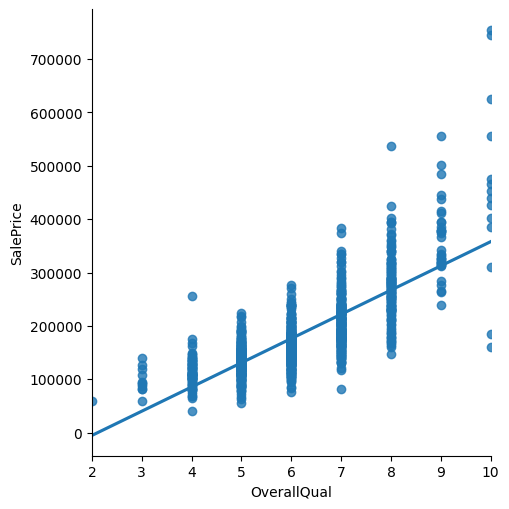

In [19]:
%matplotlib inline
sns.lmplot(data=df_ohe, x="OverallQual", y="SalePrice", ci=None)
plt.show()

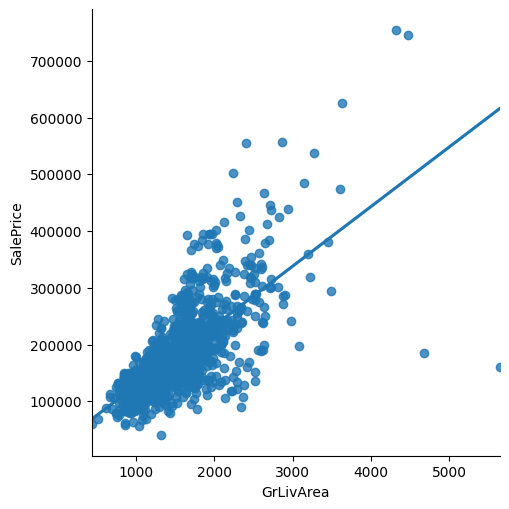

In [23]:
sns.lmplot(data=df_ohe, x="GrLivArea", y="SalePrice", ci=None)
plt.show()

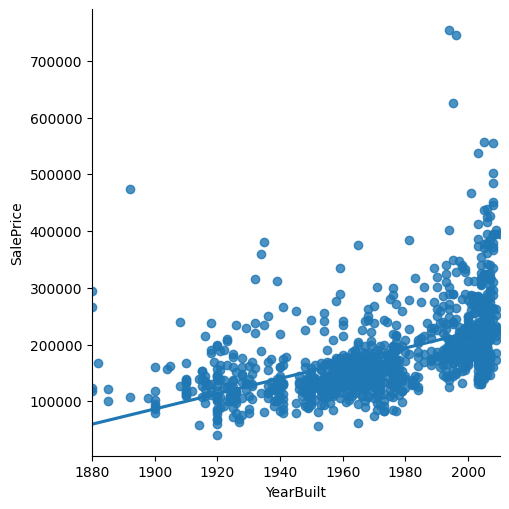

In [24]:
sns.lmplot(data=df_ohe, x="YearBuilt", y="SalePrice", ci=None)
plt.show()

From the data above we can see positive correlation among all the compared variables against the key variable sale price.

There are also a number of outliers that will need to be addressed later when it comes to preparing the data for our ml pipeline.

One other thing however, interesting trends appear when we visualise the data whilst sepeating the houses into their overall quality scores.

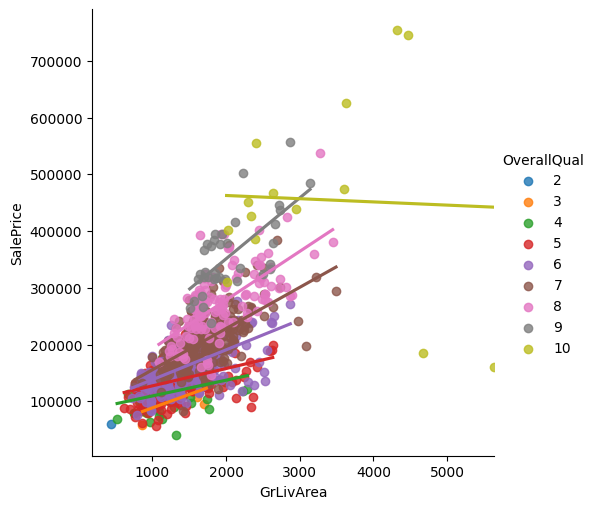

In [ ]:
sns.lmplot(data=df_ohe, x="GrLivArea", y="SalePrice", ci=None, hue='OverallQual')
plt.show()

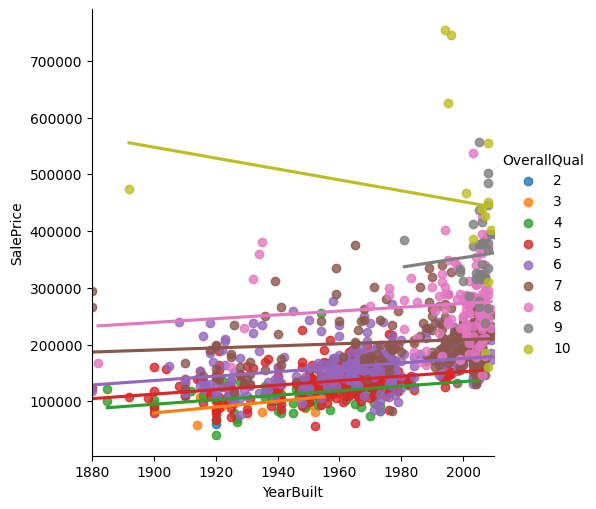

In [ ]:
sns.lmplot(data=df_ohe, x="YearBuilt", y="SalePrice", ci=None, hue='OverallQual' )
plt.show()

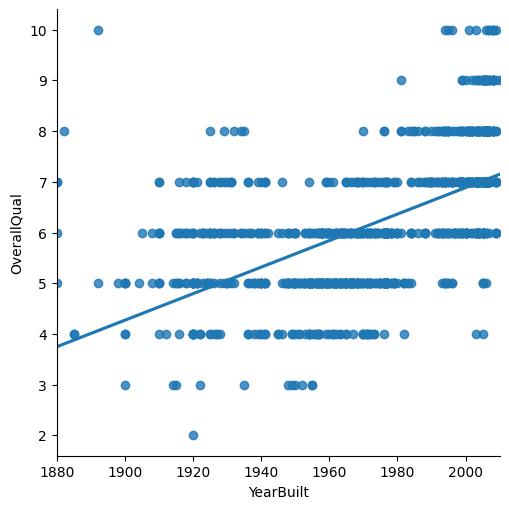

In [22]:
sns.lmplot(data=df_ohe, x="YearBuilt", y="OverallQual", ci=None, hue=)
plt.show()

The graphs show that there is a strong trend between the quality of the house and the year that it was built. This suggests that it may be worth taking overall quality as the prefered comparison and dropping year built, but we can test this properly later with smart correlation selection when we prepare our data. 

---

# Conclusion and Next Steps

The correlations and plots confirm a number of things that help us answer the first business question. 

"The client is interested in discovering how house attributes correlate with the typical house Sale Price."

* The sale price of a house is typically higher for larger houses
* The sale price of a house is typically higher for houses of higher overall quality
* The sale price of a house is typically higher if it was built recently, however this may be because a newer house is higher in overall quality.